# Multi-class Classification and Neural Networks

## 1 Multi-class classification

For this excercise, you will use logistic regression to recognize handwritten digits (from 0 to 9). Multi-class classification is performed on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using one-vs-all classification.

### 1.1 Dataset

There are 5000 training examples in *ex3data1.mat*, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This results in a 5000 by 400 matrix **X** where every row is a training
example for a handwritten digit image.

In [1]:
# imports 
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize, fmin_cg
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the dataset from ex3data1.mat file
dataset = sio.loadmat('ex3data1.mat')
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = dataset['X']
y = dataset['y']
print(f'Training data X shape: {X.shape}')
print(f'Labels y shape: {y.shape}')

Training data X shape: (5000, 400)
Labels y shape: (5000, 1)


In [4]:
# instead of labeling 0s with 10s (because this tutorial is initially created for Matlab
# which uses 1-labeling of everything which is annoying as fuck)
# this will enable simpler looping later
y[:500,:] = 0 

### 1.2 Visualizing the data

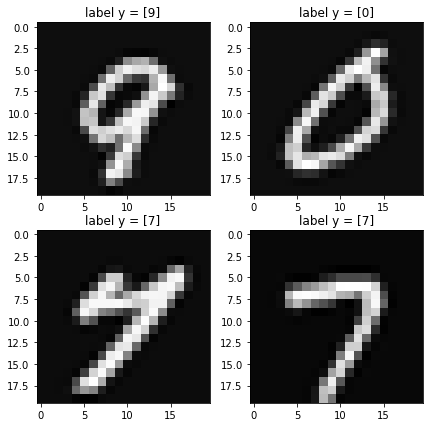

In [5]:
rand_indices = np.random.randint(low=0, high=X.shape[0], size=4)
plt.figure(figsize=(7,7))
for i, rand_index in enumerate(rand_indices):
    plt.subplot(2,2,i+1)
    plt.title(f'label y = {y[rand_index]}')
    plt.gray()
    plt.imshow(X[rand_index].reshape(20,20).T)

### 1.3 Vectorized (regularized) logististic regression

It is much easier to write code (not to say, much more computationally efficient) in vectorized form rather using loops. 

Logistic regression hypothesis is defined as:
$$ h_{\theta}(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function defined as:
$$ g(z) = \frac{1}{1+e^{-z}} $$

Cost function in logistic regression is (no regularization parameter):
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{i})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))] $$

and the gradient of regularizationthe cost is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} $$

Regularized cost function in logistic regression is:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{i})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

where hypothesis is the same sigmoid activation function as in non-regularized logistic regression. 
The only new parameter is the regularized parameter $\lambda$.

Gradient of the cost is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows:
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)};  j=0$$
and
$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j};  j\geq0$$

Hint:

Vectorized form of regularized gradient descent for logistic regression can be written as:
$$ \begin{bmatrix}
    \frac{\partial J}{\partial \theta_{0}}\\
    \frac{\partial J}{\partial \theta_{1}}\\
    \frac{\partial J}{\partial \theta_{2}}\\
    ...\\
    \frac{\partial J}{\partial \theta_{n}}
    \end{bmatrix} = \frac{1}{m}X^T(h_{\theta}(x) - y) + \frac{\lambda}{m} \theta
$$

In [6]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-1 * z))

def regCostFunction(theta, X, y, _lambda):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    pred = sigmoid(X @ theta)
    J = np.mean((-y * np.log(pred)) - ((1-y) * np.log(1-pred)))
    J_reg = J + (_lambda/(2*m) * np.sum(np.square(theta[1:])))
    return J_reg

def regGrad(theta, X, y, _lambda):
    m = len(y)
    theta = theta.reshape(-1,1)
        
    pred = sigmoid(X @ theta)
    grad = 1/m * X.T @ (pred - y)
    grad[1:] = grad[1:] + (_lambda * theta[1:,] / m)
    return grad.flatten()

In [7]:
# testing cost function and gradient
theta_t = np.array([-2, -1, 1, 2]).reshape(-1,1)
X_t = np.concatenate((np.ones((5,1)), 
                      (np.arange(1,16)/10).reshape(3,5).T), axis=1)
y_t = np.array([1, 0, 1, 0, 1]).reshape(-1,1)
_lambda_t = 3
J = regCostFunction(theta_t, X_t, y_t, _lambda_t)
print(f'Cost function: {J}')
print(f'Expected cost: 2.534819')
      
grad = regGrad(theta_t, X_t, y_t, _lambda_t)     
print(f'Gradients: {np.squeeze(grad)}')
print('Expected gradients: [0.146561 -0.548558 0.724722 1.398003]')

Cost function: 2.534819396109744
Expected cost: 2.534819
Gradients: [ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients: [0.146561 -0.548558 0.724722 1.398003]


### 1.4 One-vs-all classification

One-vs-all classifier is defined as multiple regularized logistic regression classifiers, one for each of the *K* classes in the label portion of the dataset. 
For the observed dataset, $ K = 10 $. 

Training is done using BFGS optimizer method, just like in binary logistic regression classifier.

In [8]:
def optimizeTheta(initial_theta, X, y, _lambda):
    # optimization performed using fmin_cg function as a match to a Matlab's fmincg function (c) Carl Edward Rasmussen
    # fmin = fmin_cg(f=regCostFunction, 
    #                fprime=regGrad,
    #                x0=initial_theta, 
    #                args=(X, y, _lambda), 
    #                maxiter=50,
    #                disp=True,
    #                full_output=False)
    fmin = minimize(regCostFunction, initial_theta, args=(X, y, _lambda), jac=regGrad, method='TNC') # pretty slow :/
    fmin = fmin.x
    return fmin

def oneVsAllClassifier(X, y, num_labels, _lambda):
    m, n = X.shape 
    X = np.concatenate((np.ones((m,1)), X), axis=1)
    theta = np.zeros(shape=(num_labels, n+1))
    initial_theta = np.zeros(shape=(n+1,1)).reshape(-1)
    
    for i in range(num_labels):
        y_i = np.array([1 if _y_i == i else 0 for _y_i in y]).reshape(-1,1) # ¯\_(ツ)_/¯
        theta[i,:] = optimizeTheta(initial_theta, X, y_i, _lambda)
    return theta
    
def predict(theta, X):
    m = X.shape[0]
    num_labels = theta.shape[0] 
    X = np.concatenate((np.ones((m,1)), X), axis=1)
    
    y_predict_raw = np.zeros((m, num_labels))
    y_predict_raw = sigmoid(X @ theta.T) # (5000,10) = (5000,401) x (401, 10)
    
    # there is probably a better way for finding column index of max element of each row, but fuck it, it works
    return np.where(y_predict_raw == np.max(y_predict_raw, axis=1).reshape(-1,1))[1].reshape(-1,1)

def accuracy(pred, y):
    return np.mean(pred==y)*100

In [9]:
# training
_lambda = 0.1 # regularization param
input_layer_size = 400 # 20*20 pixel images
num_labels = 10 # number of labels

theta = oneVsAllClassifier(X, y, num_labels, _lambda)
theta.shape

(10, 401)

In [10]:
# evaluating
pred = predict(theta, X) 
acc = accuracy(pred, y)
print(f'accuracy score (out of 100%): {round(acc,2)}%')

accuracy score (out of 100%): 96.46%


## 2 Neural Networks